In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import Precision, Recall

from sklearn import metrics
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import os
import requests 

In [2]:
img_size = (450, 450)

In [3]:
def data_preprocessing(path):
    datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255,
                                                              zoom_range=0.2,
                                                              horizontal_flip=True,
                                                              vertical_flip=True
                                                             )

    generator = datagen.flow_from_directory(
    path,
    batch_size=25,
    class_mode='categorical',
    target_size=img_size,
    color_mode="rgb"
    )

    return generator

In [4]:
train_generator = data_preprocessing("C:\\Users\\PRABHUGURAV\\OneDrive\\Documents\\archive (1)\\Split_smol\\train")
validation_generator = data_preprocessing("C:\\Users\\PRABHUGURAV\\OneDrive\\Documents\\archive (1)\\Split_smol\\val")

Found 696 images belonging to 9 classes.
Found 181 images belonging to 9 classes.



Dimensione dell'immagine: (450, 450, 3)



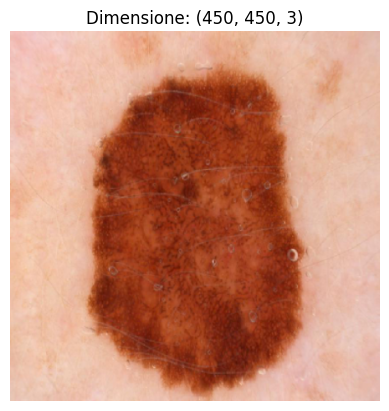

In [5]:
sample_image, _ = train_generator.next()
image_shape = sample_image.shape[1:]
num_channels = image_shape[-1]

print("\nDimensione dell'immagine:", image_shape)
print()
plt.imshow(sample_image[0])
plt.title(f"Dimensione: {image_shape}")
plt.axis('off')
plt.show()

In [6]:
act_func = tf.keras.layers.LeakyReLU(alpha=0.1)

In [7]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation=act_func, padding='same', input_shape=(img_size[0], img_size[1], 3), kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(axis=-1),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Conv2D(filters=128, kernel_size=5, activation=act_func, padding='same', kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(axis=-1),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Conv2D(filters=128, kernel_size=5, activation=act_func, padding='same', kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(axis=-1),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Conv2D(filters=256, kernel_size=3, activation=act_func, padding='same', kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(axis=-1),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Conv2D(filters=512, kernel_size=3, activation=act_func, padding='same', kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(axis=-1),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation=act_func),
    tf.keras.layers.BatchNormalization(axis = -1),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(256, activation=act_func),
    tf.keras.layers.BatchNormalization(axis = -1),
    tf.keras.layers.Dropout(0.4),

    tf.keras.layers.Dense(9, activation='softmax')

])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 450, 450, 64)      1792      
                                                                 
 batch_normalization (Batch  (None, 450, 450, 64)      256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 225, 225, 64)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 225, 225, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 225, 225, 128)     204928    
                                                                 
 batch_normalization_1 (Bat  (None, 225, 225, 128)     

In [8]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', Precision(), Recall()])
history_model = model.fit(train_generator, epochs = 30, validation_data = validation_generator)


Epoch 1/30


28/28 [==============================] - 1466s 52s/step - loss: 2.3218 - accuracy: 0.3132 - precision: 0.3482 - recall: 0.1911 - val_loss: 16.6317 - val_accuracy: 0.1326 - val_precision: 0.1341 - val_recall: 0.1326
Epoch 2/30
28/28 [==============================] - 1347s 48s/step - loss: 1.7505 - accuracy: 0.4325 - precision: 0.5195 - recall: 0.3261 - val_loss: 6.6835 - val_accuracy: 0.1602 - val_precision: 0.1698 - val_recall: 0.1492
Epoch 3/30
28/28 [==============================] - 1515s 54s/step - loss: 1.7139 - accuracy: 0.4253 - precision: 0.4978 - recall: 0.3319 - val_loss: 3.9255 - val_accuracy: 0.1989 - val_precision: 0.2015 - val_recall: 0.1492
Epoch 4/30
28/28 [==============================] - 1405s 50s/step - loss: 1.4860 - accuracy: 0.4598 - precision: 0.5316 - recall: 0.3621 - val_loss: 2.5474 - val_accuracy: 0.2541 - val_precision: 0.2982 - val_recall: 0.1878
Epoch 5/30
28/28 [==============================] - 1785s 64s/step - loss: 1.5121 - accuracy: 0.

In [9]:
class_names = list(train_generator.class_indices.keys())

def predict_disease(model, img_path):
  img = tf.keras.utils.load_img(img_path, target_size=(img_size[0], img_size[1], 3), color_mode = 'rgb')
  array = tf.keras.utils.img_to_array(img)
  array = array / 255.0

  img_array = np.expand_dims(array, axis=0)
  preds = model.predict(img_array)

  #formatted_predictions = []
  for prediction in preds:
      formatted_predictions = [f'{value:.2f}' for value in prediction]

  top_prob_index = np.argmax(formatted_predictions)
  top_prob = round(float(formatted_predictions[top_prob_index].replace(",", "."))*100, 2)

  print("Probability for each class:", sorted(zip(class_names, formatted_predictions), key=lambda x: x[1], reverse=True))

  plt.imshow(tf.keras.utils.load_img(img_path, target_size=(img_size[0], img_size[1],3), color_mode = 'rgb'))
  plt.axis('off')
  plt.title(f"Class: {list(class_names)[top_prob_index]}; Prob: {top_prob}%")
  plt.show()

1/1 [==============================] - 1s 1s/step
Probability for each class: [('Actinic keratosis', '0.41'), ('Tinea Ringworm Candidiasis', '0.27'), ('Atopic Dermatitis', '0.15'), ('Dermatofibroma', '0.11'), ('Squamous cell carcinoma', '0.07'), ('Benign keratosis', '0.00'), ('Melanocytic nevus', '0.00'), ('Melanoma', '0.00'), ('Vascular lesion', '0.00')]


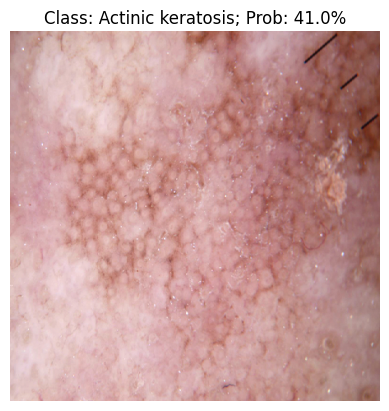

In [10]:
predict_disease(model, "C:\\Users\\PRABHUGURAV\\OneDrive\\Documents\\archive (1)\\Split_smol\\val\\Actinic keratosis\\ISIC_0025825.jpg")

In [12]:
model.save("savedSkinModel.keras")

1/1 [==============================] - 0s 406ms/step
Probability for each class: [('Actinic keratosis', '0.41'), ('Melanoma', '0.27'), ('Tinea Ringworm Candidiasis', '0.15'), ('Dermatofibroma', '0.11'), ('Melanocytic nevus', '0.07'), ('Atopic Dermatitis', '0.00'), ('Squamous cell carcinoma', '0.00'), ('Benign keratosis', '0.00'), ('Vascular lesion', '0.00')]


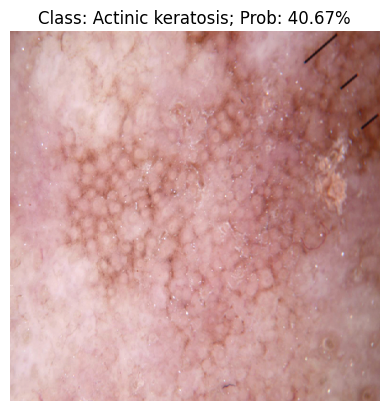

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model

class_names = ['Actinic keratosis', 'Tinea Ringworm Candidiasis', 'Atopic Dermatitis', 'Dermatofibroma', 'Squamous cell carcinoma', 'Benign keratosis', 'Melanocytic nevus', 'Melanoma', 'Vascular lesion']
img_size = (450, 450)  # Example image size; replace with your actual image size

def predict_disease(model, img_path):
    img = tf.keras.utils.load_img(img_path, target_size=img_size, color_mode='rgb')
    array = tf.keras.utils.img_to_array(img)
    array = array / 255.0

    img_array = np.expand_dims(array, axis=0)
    preds = model.predict(img_array)

    formatted_predictions = [f'{value:.2f}' for value in preds[0]]
    top_prob_index = np.argmax(preds[0])
    top_prob = round(float(preds[0][top_prob_index]) * 100, 2)

    print("Probability for each class:", sorted(zip(class_names, formatted_predictions), key=lambda x: float(x[1]), reverse=True))

    plt.imshow(tf.keras.utils.load_img(img_path, target_size=img_size, color_mode='rgb'))
    plt.axis('off')
    plt.title(f"Class: {class_names[top_prob_index]}; Prob: {top_prob}%")
    plt.show()

# Assuming you have trained and saved the model
model = load_model("savedSkinModel.keras")

predict_disease(model, "C:\\Users\\PRABHUGURAV\\OneDrive\\Documents\\archive (1)\\Split_smol\\val\\Actinic keratosis\\ISIC_0025825.jpg")
